# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [373]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [374]:
lines = np.loadtxt("../data/negative-words.txt", dtype='str', comments="#", delimiter=",", unpack=False)[200:300]
lines_count = [line + '_count' for line in lines]

print(lines)

['assult' 'astray' 'asunder' 'atrocious' 'atrocities' 'atrocity' 'atrophy'
 'attack' 'attacks' 'audacious' 'audaciously' 'audaciousness' 'audacity'
 'audiciously' 'austere' 'authoritarian' 'autocrat' 'autocratic'
 'avalanche' 'avarice' 'avaricious' 'avariciously' 'avenge' 'averse'
 'aversion' 'aweful' 'awful' 'awfully' 'awfulness' 'awkward' 'awkwardness'
 'ax' 'babble' 'back-logged' 'back-wood' 'back-woods' 'backache'
 'backaches' 'backaching' 'backbite' 'backbiting' 'backward'
 'backwardness' 'backwood' 'backwoods' 'bad' 'badly' 'baffle' 'baffled'
 'bafflement' 'baffling' 'bait' 'balk' 'banal' 'banalize' 'bane' 'banish'
 'banishment' 'bankrupt' 'barbarian' 'barbaric' 'barbarically' 'barbarity'
 'barbarous' 'barbarously' 'barren' 'baseless' 'bash' 'bashed' 'bashful'
 'bashing' 'bastard' 'bastards' 'battered' 'battering' 'batty' 'bearish'
 'beastly' 'bedlam' 'bedlamite' 'befoul' 'beg' 'beggar' 'beggarly'
 'begging' 'beguile' 'belabor' 'belated' 'beleaguer' 'belie' 'belittle'
 'belittled

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [375]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [376]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data_jeremy(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        cv = CountVectorizer(ngram_range=(1, 2))
        X_cv = cv.fit_transform(movie_data.review)
        fitted_transformations.append(cv)
#         print(v.fit(movie_data.review).vocabulary_)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)
    else: # transform() 
        X_cv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_cv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_cv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
#     movie_data['doesn\'t_count'] = movie_data['review'].str.count("doesn't")
#     movie_data['does_not_count'] = movie_data['review'].str.count("does not")
    
#     print(p)
#     for word in lines:
#         movie_data[word + '_count'] = movie_data['review'].str.count(word)
    
#     movie_data['bad_count'] = movie_data['review'].str.count("bad")
#     movie_data['worst_count'] = movie_data['review'].str.count("worst")
#     movie_data['ellipsis_ratio'] = movie_data['review'].str.split('...').str.len() / movie_data['review'].str.split(' ').str.len()

#     X_quant_features = movie_data[["word_count", "punc_count", "bad_count", "worst_count", "ellipsis_ratio"]]
    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [377]:

# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [378]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=999)

print("Number of fits stored in `fitted_transformations` list: ")
print(fitted_transformations)

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


In [379]:
# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [380]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

/Users/jeremyodell/opt/anaconda3/envs/machineleaning/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(


{'Pos': 9965, 'Neg': 10035, 'TP': 5151, 'TN': 4940, 'FP': 5095, 'FN': 4814, 'Accuracy': 0.50455, 'Precision': 0.5027327737653718, 'Recall': 0.5169091821374812, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [381]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9965, 'Neg': 10035, 'TP': 9965, 'TN': 10035, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [382]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9965, 'Neg': 10035, 'TP': 9965, 'TN': 10035, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [383]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9965, 'Neg': 10035, 'TP': 9546, 'TN': 9873, 'FP': 162, 'FN': 419, 'Accuracy': 0.97095, 'Precision': 0.9833127317676144, 'Recall': 0.9579528349222278, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [384]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9965, 'Neg': 10035, 'TP': 9965, 'TN': 10035, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [385]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=9999999.0)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9965, 'Neg': 10035, 'TP': 8684, 'TN': 9803, 'FP': 232, 'FN': 1281, 'Accuracy': 0.92435, 'Precision': 0.9739793629430238, 'Recall': 0.871450075263422, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [386]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9965, 'Neg': 10035, 'TP': 7549, 'TN': 8079, 'FP': 1956, 'FN': 2416, 'Accuracy': 0.7814, 'Precision': 0.7942135718043135, 'Recall': 0.7575514300050176, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

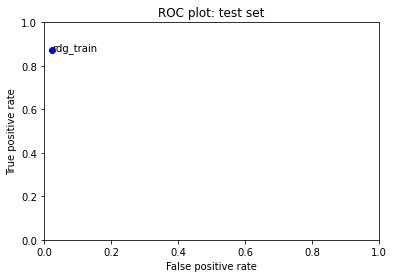

In [387]:
fits = [rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [388]:
ols_predictions = nbs.predict(X_train)

### let's look at some false positives:

In [389]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.5): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
488
What did the director think? Everybody who has read the biography of Artemisia is left impressed by her guts to face a public rape trial in Renaissance times and even suffer torture in order to show that Tassi was guilty. That fact shows the real independence and emancipation - in her most terrible hour she stands her MAN. Why do movies depicting Renaissance have to be so clinically beautiful and romantic, are we afraid to see the gritty side of life or has the Hollywood happy-happy-mood won? While I would always defend a director's freedom to create his own reality in a movie I cannot make sense of turning Artimisia's life story on its head. Very disappointing choice by the makers of this film.
* * * * * * * * * 
758
I'm not a big fan of the Stooges' slapstick, but I find their history interesting. I've recently tried to check out stuff from each Stooge era, but the opportunity to see Joe shorts doesn't seem to come easy; this is the only one I've seen

6496
I'm a Jean Harlow fan, because she had star quality. I don't think her movies are good and I don't even think that she was a good actress, but she certainly was Great in comedies. Every bit of comedy in The Girl from Missouri is very good. But this movie is perhaps more like a love story. Jean Harlow is wonderful in this one and you can forget the rest of the cast - their performances bring nothing new. It always impresses me much to think that Harlow's beautiful body was that of an ill woman. Well, in this movie she does look beautiful.
* * * * * * * * * 
6596
I know nothing of the Iliad so can not comment on it's accuracy to that story. However, as a stand alone film I found this very boring. The battle scenes tried to be large and spectacular but they were just obvious CGI.<br /><br />The acting is poor and no doubt Brad Pitt was cast just to attract the ladies. But he does not make a good warrior, too pretty i am afraid.<br /><br />Good points are is the design. This film does

7532
While I count myself as a fan of the Babylon 5 television series, the original movie that introduced the series was a weak start. Although many of the elements that would later mature and become much more compelling in the series are there, the pace of The Gathering is slow, the makeup somewhat inadequate, and the plot confusing. Worse, the characterization in the premiere episode is poor. Although the ratings chart shows that many fans are willing to overlook these problems, I remember The Gathering almost turned me off off what soon grew into a spectacular series.
* * * * * * * * * 
7575
Question: how does a bourgeois director treat a subject like immigration ? Answer: by turning it into an existential alienation parable.<br /><br />Yes, we're back in the early 90s, just after the disintegration of the Eastern block and the subsequent flooding of immigrants in the European Union, and what better way to deal with the subject than making a film about an existentially alienated mid

11024
For getting so many positive reviews, this movie really disappointed me! It is slow moving and long. At times the story is not clear, particularly in the evolving relationships among characters. My advice? Read the book, it's a fabulous story which loses it's impact on screen.
* * * * * * * * * 
11056
After being hugely entertained by Mr. Brosnan's performance as a cad in \The Tailor of Panama\" (which I rate 10/10 across the board: casting, acting, script, story, editing, pace, music, emotional impact, etc.), I enthusiastically anticipated this film. I was hugely disappointed. It is a script reading not a film, vulgar for the sake of being vulgar, bankrupt in every way that \"The Tailor of Panama\" is rich and satisfying. Blame it on the screen writing and directing. I sat in the theater waiting for the \"good part;\" it never came. I neither laughed nor cried, although one line of dialog did make me smile. Worth $7? Hardly."
* * * * * * * * * 
11148
I found the documentary enti

15046
I recently watched Belle Epoque, thinking it might be wonderful as it did win an Oscar for Best Foreign Language Film. I was a bit underwhelmed by the predictability and simplicity of the film. Maybe the conflict I had was that from the time the movie was filmed to now, the plot of a man falling for beautiful women and eventually falling for the good girl has been done so many times. Aside from predictability of the plot, some scenes in the film felt really out of place with the storyline (ex. a certain event at the wedding). At times the film was a bit preachy in it's ideas and in relation to the Franco era the film was set in and the Church. The only thing the film had going for it was the cutesy moments, the scenery, and the character of Violeta being a strong, independent woman during times when women were not really associated with those characteristics.
* * * * * * * * * 
15174
Horrible film with bits of the Ramones strewn about. Your worse than average 1970's/80's comedy f

17659
This film reminds me of how college students used to protest against the Vietnam War. As if, upon hearing some kids were doing without cheeseburgers in Cow Dung Collehe, the President was going to immediately change all US foreign policy.<br /><br />The worst thing is that, while dangerous, the concept of a policy based on if the USSR and US went to war it could mean the end of the world, WORKED. The US and USSR NEVER WENT TO WAR.<br /><br />Had we only conventional weapons, the notion of yet another war, a \win-able\" war, in Europe and Asia was not unthinkable.<br /><br />Not that I think they should get rid of this movie. It should be seen by film students as a splendid example of \"How NOT to make a film.\"<br /><br />It should be 0 stars or maybe black holes..."
* * * * * * * * * 
17676
I have seen romantic comedies and this is one of the easiest/worst attempts at one. A lot of the scenes work in a plug-and-play manner inserted strictly to conform to the romantic-comedy genr

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [390]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 1347, 'TN': 1130, 'FP': 1335, 'FN': 1188, 'Accuracy': 0.4954, 'Precision': 0.5022371364653244, 'Recall': 0.5313609467455621, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [391]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 2098, 'TN': 2049, 'FP': 416, 'FN': 437, 'Accuracy': 0.8294, 'Precision': 0.8345266507557677, 'Recall': 0.8276134122287968, 'desc': 'svm_test'}


### MODEL: logistic regression

In [392]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 2102, 'TN': 2056, 'FP': 409, 'FN': 433, 'Accuracy': 0.8316, 'Precision': 0.8371166865790521, 'Recall': 0.8291913214990138, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [393]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 1825, 'TN': 1833, 'FP': 632, 'FN': 710, 'Accuracy': 0.7316, 'Precision': 0.7427757427757428, 'Recall': 0.7199211045364892, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [394]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 2093, 'TN': 2053, 'FP': 412, 'FN': 442, 'Accuracy': 0.8292, 'Precision': 0.8355289421157684, 'Recall': 0.8256410256410256, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [395]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 1924, 'TN': 2271, 'FP': 194, 'FN': 611, 'Accuracy': 0.839, 'Precision': 0.9084041548630784, 'Recall': 0.7589743589743589, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [396]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 1887, 'TN': 1911, 'FP': 554, 'FN': 648, 'Accuracy': 0.7596, 'Precision': 0.7730438344940598, 'Recall': 0.744378698224852, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

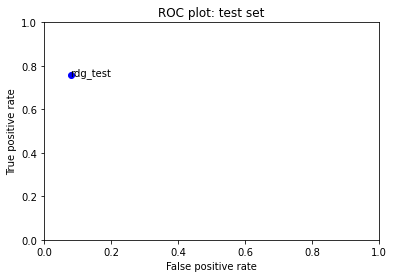

In [397]:
fits = [rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [398]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../data/moviereviews_test.tsv', my_random_seed=999, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [399]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.52044


In [400]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [401]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [402]:
my_submission.shape

(25000, 2)

In [403]:
# export submission file as pdf
# CHANGE FILE PATH: 
# my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation